In [35]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [36]:
SCRIPT_PATH='.'
module_path = os.path.abspath(os.path.join(SCRIPT_PATH))
if module_path not in sys.path:
    sys.path.append(module_path)

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
from utils import load_daily_state_cases, load_patient_data, get_delay_onset_confirmation_probabilities
from utils import adjust_onset_for_right_censorship, confirmed_to_onset
from utils import create_and_run_model, df_from_model, reparametrize
from utils import aggregate_results, plot_rt

# Reference https://rt.live/

In [39]:
states = load_daily_state_cases()

Not all states have updated
state
AK   2020-05-28
AL   2020-05-28
AR   2020-05-28
AZ   2020-05-28
CA   2020-05-28
CO   2020-05-28
CT   2020-05-28
DC   2020-05-28
DE   2020-05-28
FL   2020-05-28
GA   2020-05-28
HI   2020-05-28
IA   2020-05-28
ID   2020-05-28
IL   2020-05-28
IN   2020-05-28
KS   2020-05-28
KY   2020-05-28
LA   2020-05-28
MA   2020-05-28
MD   2020-05-28
ME   2020-05-28
MI   2020-05-28
MN   2020-05-28
MO   2020-05-28
MS   2020-05-28
MT   2020-05-28
NC   2020-05-28
ND   2020-05-28
NE   2020-05-28
NH   2020-05-28
NJ   2020-05-28
NM   2020-05-28
NV   2020-05-28
NY   2020-05-28
OH   2020-05-28
OK   2020-05-28
OR   2020-05-28
PA   2020-05-28
RI   2020-05-28
SC   2020-05-28
SD   2020-05-28
TN   2020-05-28
TX   2020-05-28
UT   2020-05-28
VA   2020-05-28
VT   2020-05-28
WA   2020-05-28
WI   2020-05-28
WV   2020-05-28
WY   2020-05-28
Name: date, dtype: datetime64[ns]
state  date      
CO     2020-05-12   -20.0
Name: positive, dtype: float64
state  date      
HI     2020-05-15   -1.

In [40]:
states.head()

positive  negative  pending  hospitalizedCurrently  \
state date                                                             
AK    2020-03-06       0.0       8.0      1.0                    NaN   
      2020-03-07       0.0      12.0      2.0                    NaN   
      2020-03-08       0.0      14.0      6.0                    NaN   
      2020-03-09       0.0      23.0      9.0                    NaN   
      2020-03-10       0.0      23.0      9.0                    NaN   

                  hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
state date                                                                  
AK    2020-03-06                     NaN             NaN              NaN   
      2020-03-07                     NaN             NaN              NaN   
      2020-03-08                     NaN             NaN              NaN   
      2020-03-09                     NaN             NaN              NaN   
      2020-03-10                     NaN             NaN              NaN   

                  onVentilatorCurrently  onVentilatorCumulative  recovered  \
state date                                                                   
AK    2020-03-06                    NaN                     NaN        NaN   
      2020-03-07                    NaN                     NaN        NaN   
      2020-03-08                    NaN                     NaN        NaN   
      2020-03-09                    NaN                     NaN        NaN   
      2020-03-10                    NaN                     NaN        NaN   

                  ... hospitalized total totalTestResults posNeg  fips  \
state date        ...                                                    
AK    2020-03-06  ...          NaN     9                8      8     2   
      2020-03-07  ...          NaN    14               12     12     2   
      2020-03-08  ...          NaN    20               14     14     2   
      2020-03-09  ...          NaN    32               23     23     2   
      2020-03-10  ...          NaN    32               23     23     2   

                  deathIncrease  hospitalizedIncrease  negativeIncrease  \
state date                                                                
AK    2020-03-06            NaN                   NaN               NaN   
      2020-03-07            0.0                   0.0               4.0   
      2020-03-08            0.0                   0.0               2.0   
      2020-03-09            0.0                   0.0               9.0   
      2020-03-10            0.0                   0.0               0.0   

                  positiveIncrease  totalTestResultsIncrease  
state date                                                    
AK    2020-03-06               NaN                       NaN  
      2020-03-07               0.0                       4.0  
      2020-03-08               0.0                       2.0  
      2020-03-09               0.0                       9.0  
      2020-03-10               0.0                       0.0  

[5 rows x 25 columns]

In [41]:
patients = load_patient_data()
patients = patients[(patients["Onset"] >= "2020-04-01")]

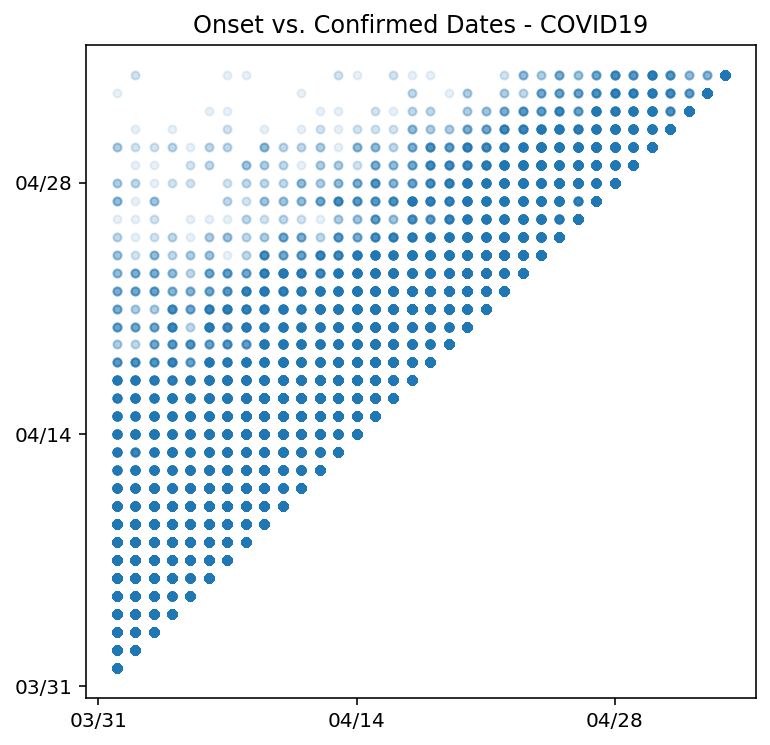

In [42]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot_date(patients['Onset'], patients['Confirmed'], ydate=True, alpha=.1, lw=0, markersize=4)
ax.set_title("Onset vs. Confirmed Dates - COVID19")

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=2)

for axis in [ax.xaxis, ax.yaxis]:
   axis.set_major_formatter(formatter)
   axis.set_major_locator(locator)

plt.savefig("reports/onset_confirmed.pdf", bbox_inches="tight")
plt.show()
plt.close()

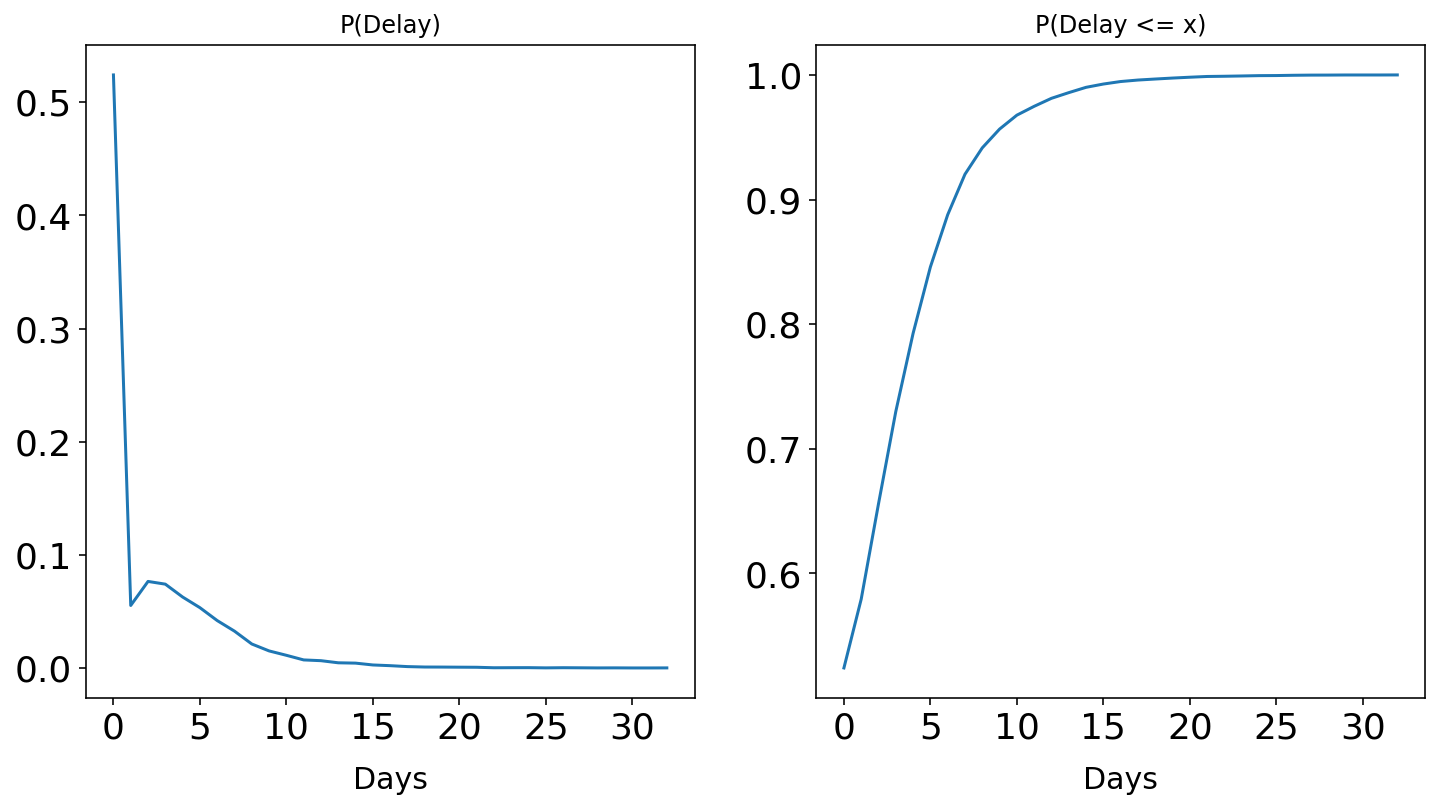

In [43]:
p_delay = get_delay_onset_confirmation_probabilities(patients)

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
plot_a = axes[0]
plt.setp(plot_a.get_xticklabels(), fontsize=18)
plt.setp(plot_a.get_yticklabels(), fontsize=18)
p_delay.plot(title='P(Delay)', ax=plot_a)
plot_a.set_xlabel("Days", fontsize=15, labelpad=10)
    
plot_b = axes[1]
p_delay.cumsum().plot(title='P(Delay <= x)', ax=plot_b)
plt.setp(plot_b.get_xticklabels(), fontsize=18)
plt.setp(plot_b.get_yticklabels(), fontsize=18)
plot_b.set_xlabel("Days", fontsize=15, labelpad=10)
plt.savefig("reports/delay_onset_confirmation_probabilities.pdf", bbox_inches="tight")
plt.show()
plt.close()

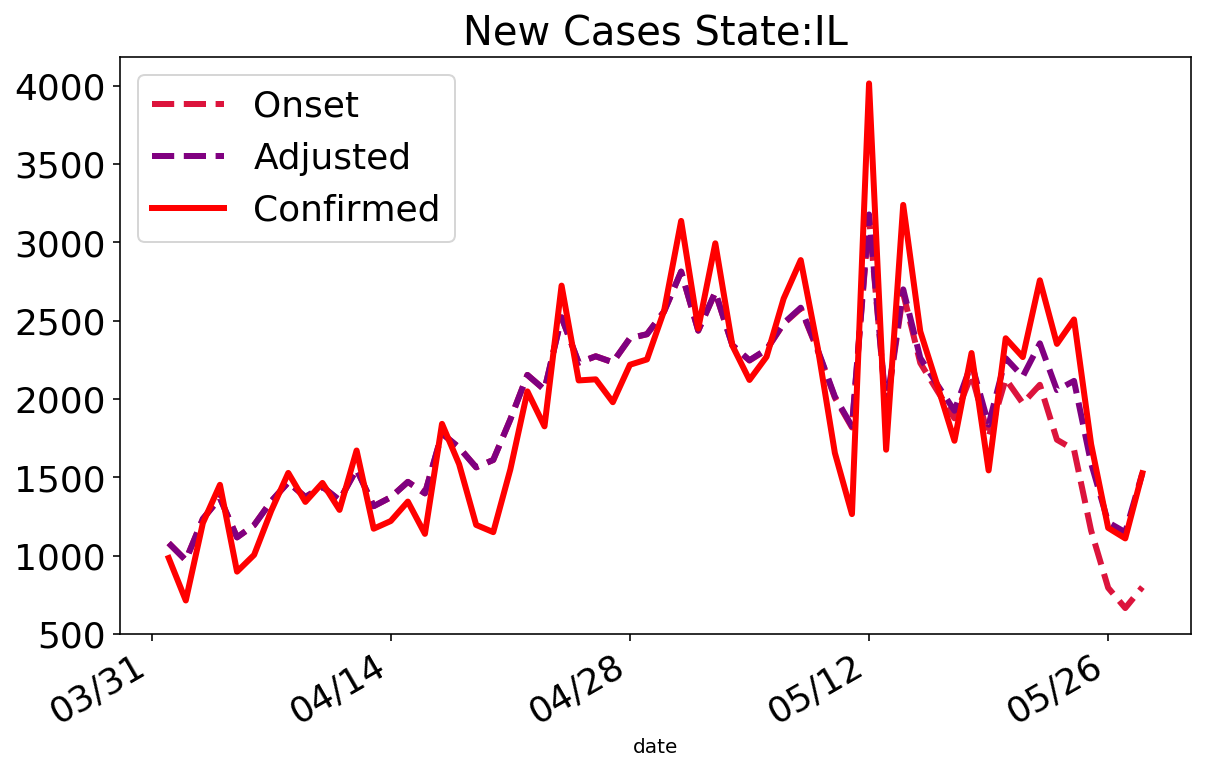

In [44]:
state = 'IL'
confirmed = states.xs(state).positive.diff().dropna()
confirmed = confirmed.loc["2020-04-01":]
onset = confirmed_to_onset(confirmed, p_delay)
onset = onset.loc["2020-04-01":]
adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
figure, plot = plt.subplots(figsize=(9, 6))
onset.plot(linestyle='--', lw=3, color='crimson', label="Onset",ax=plot, x_compat=True)
adjusted.plot(linestyle='dashed', lw=3, color='purple', label="Adjusted", ax=plot, x_compat=True)
confirmed.plot(linestyle='solid', lw=3, color='red', label="Confirmed", ax=plot, x_compat=True)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plot.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plot.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.title("New Cases State:" + state,fontsize=20)
plt.gcf().subplots_adjust(bottom=0.3)
plt.gcf().subplots_adjust(left=0.3)
figure.tight_layout(pad=3.0)
plt.savefig("reports/onset_adjusted_confirmed_new_case_" + state + ".pdf", bbox_inches="tight")
plt.show()
plt.close()

In [30]:
models = dict()

In [31]:
lookup_states = ["CA", "IL", "NY"]
gb = states.groupby("state")
for state in lookup_states:
    print(state)
    grp = gb.get_group(state)
       
    if state in models:
        print(f'Skipping {state}, already in cache')
        continue
    
    models[state] = create_and_run_model(state, states, p_delay)


CA


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 5 divergences: 100%|██████████| 20000/20000 [00:51<00:00, 390.95draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


IL


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 4 divergences: 100%|██████████| 20000/20000 [00:53<00:00, 371.91draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


NY


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences: 100%|██████████| 20000/20000 [01:03<00:00, 316.69draws/s]


In [32]:
reparametrize(models)

Diverging states:
CA    5
IL    4
dtype: int64


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 4 divergences: 100%|██████████| 20000/20000 [00:56<00:00, 352.51draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 2 divergences: 100%|██████████| 20000/20000 [01:07<00:00, 296.76draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [33]:
results = aggregate_results(models)
results

mean    median  lower_90  upper_90  lower_50  upper_50
region date                                                                  
CA     2020-04-26  1.023368  1.023213  0.955101  1.096452  0.998894  1.043088
       2020-04-27  1.028497  1.026377  0.963535  1.092883  1.001557  1.042740
       2020-04-28  1.033873  1.029914  0.976918  1.096295  1.004539  1.044683
       2020-04-29  1.037175  1.031355  0.979741  1.095010  1.006384  1.045681
       2020-04-30  1.037292  1.031446  0.983462  1.094856  1.006638  1.045380
...                     ...       ...       ...       ...       ...       ...
NY     2020-05-20  0.952212  0.960086  0.837185  1.059005  0.926621  1.002502
       2020-05-21  0.993662  0.992867  0.885731  1.110696  0.958831  1.033440
       2020-05-22  1.008547  1.006102  0.882158  1.121036  0.958902  1.039350
       2020-05-23  1.001588  0.999728  0.875897  1.134972  0.958555  1.045945
       2020-05-24  0.993634  0.994250  0.853656  1.151236  0.947641  1.049350

[87 rows x 6 columns]

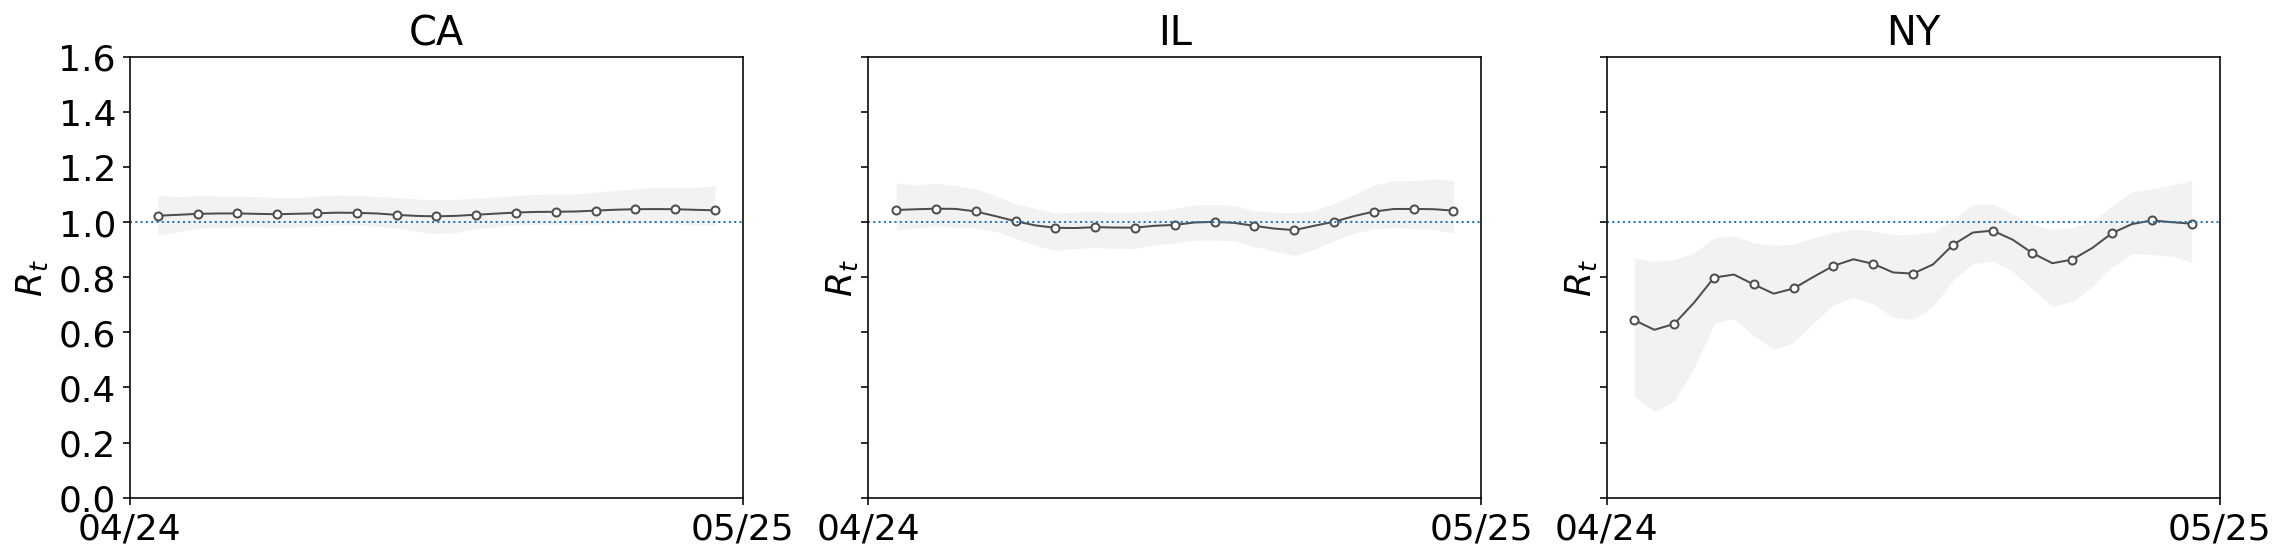

In [53]:
ncols = 3
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(16, 4),
    sharey='row')

for ax, (state, result) in zip(axes.flat, results.groupby('region')):
    plot_rt(state, result.droplevel(0), ax)

fig.tight_layout()
fig.set_facecolor('w')
plt.savefig("reports/rt_states.pdf", bbox_inches="tight")
plt.show()
plt.close()